# Hierarchical Topographic Factor Analysis
By Jeremy R. Manning ([jeremy.r.manning@dartmouth.edu](mailto:jeremy.r.manning@dartmouth.edu)) and Paxton C. Fitzpatrick ([Paxton.C.Fitzpatrick@dartmouth.edu](mailto:Paxton.C.Fitzpatrick@dartmouth.edu))

# Overview

In this demonstration, we'll be using the [BrainIAK](https://brainiak.org/) Python toolbox to apply [Hierarchical Topographic Factor Analysis (HTFA)](https://www.sciencedirect.com/science/article/abs/pii/S1053811918300715) to an fMRI dataset.

The demo will comprise three main steps:
1. Apply HTFA to the dataset to discover a basis set of network "nodes"
2. Apply a [dynamic correlation model](https://www.biorxiv.org/content/10.1101/763821v1.full.pdf) to the HTFA fits to characterize the network dynamics
3. Visualize the network dynamics in two ways:
  - An animated [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram)
  - An animated brain plot
  
# Getting started

The easiest way to run this notebook is to download the corresponding Docker image.  That will install the necessary toolboxes and dependencies, and it will also download the data you'll be analyzing.

To build the docker image, navigate to this folder and run:
```
docker build --rm --force-rm -t htfa .
```

To start the image for the first time, run:
```
docker run -it -p 8888:8888 --name htfa -v $PWD:/mnt htfa
```
and on subsequent times, run:
```
docker start htfa && docker attach htfa
```

When the docker image is started, it will automatically start a Jupyter notebook server.  Copy and paste the *third* link into a browser to interact with this notebook.

To stop running the container, run:
```
docker stop htfa
```

# Initialization

Import libraries and helper functions and load the [dataset](https://drive.google.com/open?id=1IBA39ZZjeGS1u_DvZdiw1AZZQMS3K5q0).  The dataset we'll be analyzing is a subset of the story listening dataset collected by [Simony et al. (2016)](https://www.nature.com/articles/ncomms12141).

In [64]:
# the next two lines suppress a (meaningless) warning about the graphics backend
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

from brainiak.factoranalysis.htfa import HTFA
import holoviews as hv
import nibabel as nb
import nilearn as nl
import nltools as nlt
import timecorr as tc
import seaborn as sns
import matplotlib.pyplot as mpl

from mpi4py import MPI
from multiprocessing import Pool

import os, sys
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, animate_chord, animate_connectome

from IPython.display import HTML

%matplotlib inline

In [2]:
# data
intact = lsdir('/data/Pieman2/sub-*/func/*intact*.nii.gz')
scrambled = lsdir('/data/Pieman2/sub-*/func/*word*.nii.gz')

combined_fnames = list.copy(intact)
combined_fnames.extend(scrambled)
mask = '/data/Pieman2/masks/avg152T1_gray_3mm.nii.gz'

# Fit HTFA to data

First we need to convert the dataset into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt).  Consistent with CMU format, nilearn expects the data matrices to have number-of-timepoints rows and number-of-voxels columns.  BrainIAK expects the data in the transpose of that format-- number-of-voxels by number-of-timepoints matrices. We can easily convert between the two formats using the map function.

After wrangling the data, we'll fit HTFA to the full dataset to identify network nodes.

In [3]:
# convert data to CMU format
cmu_data = [nii2cmu(f) for f in combined_fnames]

In [5]:
# convert to HTFA format
htfa_data = [{'R': x['R'], 'Z': x['Y'].T} for x in cmu_data]

In [8]:
# configure MPI:
#  - if the local environment supports MPI, do computations in parallel (fast!)
#  - if MPI is not supported, do computations in serial (slower)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    import logging
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [9]:
# set up HTFA model
K = 25 #number of nodes; decrease to speed up analysis, increase for greater accuracy (min: 1)
nvoxels, ntimepoints = htfa_data[0]['Z'].shape

htfa = HTFA(K=K,
            n_subj=len(htfa_data),
            max_global_iter=5, #decrease for speed, increase for greater accuracy (min: 1)
            max_local_iter=2,  #decrease for speed, increase for greater accuracy (min: 1)
            voxel_ratio=0.5,   #decrease for speed, increase for greater accuracy (positive; max: 1.0)
            tr_ratio=0.5,      #decrease for speed, increase for greater accuracy (positive; max: 1.0)
            max_voxel=int(nvoxels*0.05), #decrease for speed, increase for greater accuracy (max: number of voxels)
            max_tr=int(ntimepoints*0.1), #decrease for speed, increase for greater accuracy (max: number of TRs)
            verbose=False)

In [10]:
# fit HTFA to htfa_data
htfa.fit([x['Z'] for x in htfa_data], [x['R'] for x in htfa_data])

INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 ite

HTFA(K=25, max_global_iter=5, max_local_iter=2, max_tr=30, max_voxel=4417,
     n_subj=27, tr_ratio=0.5, voxel_ratio=0.5)

# Plotting HTFA global and local hub locations

We'll generate a plot where the global hub locations are shown in black, and each subject's "local" hub locations are shown in color (where each subject is assigned a different color). The hubs should be in similar (but not identical) locations across subjects.  Note: if the number of hubs or iterations is small, or if the voxel and/or timepoint subsampling is high, the final result will tend to be close to the initialized values (with little variation across subjects).  Increase `max_global_iter`, `max_local_iter`, `max_voxel`, and `max_tr` to achieve greater accuracy.

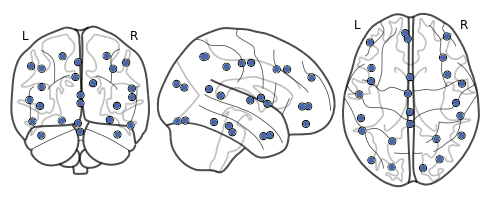

In [14]:
#set the node display properties
colors = np.repeat(np.vstack([[0, 0, 0], sns.color_palette("Spectral", htfa.n_subj)]), K, axis=0)
colors = list(map(lambda x: x[0], np.array_split(colors, colors.shape[0], axis=0))) #make colors into a list #FIXME: simplify this...
sizes = np.repeat(np.hstack([np.array(50), np.array(htfa.n_subj*[20])]), K)

#extract the node locations from the fitted htfa model
global_centers = htfa.get_centers(htfa.global_posterior_)
local_centers = [htfa.get_centers(x) for x in np.array_split(htfa.local_posterior_, htfa.n_subj)]
centers = np.vstack([global_centers, np.vstack(local_centers)])

#make the plot
nl.plotting.plot_connectome(np.eye(K*(1 + htfa.n_subj)), centers, node_color=colors, node_size=sizes);

# Compute dynamic correlations

The timeseries of activations for each node, for each participant provide a low-dimensional embedding of the original data that we can use to efficiently examine dynamic connectivity patterns.  Obtaining these embeddings requires some data wrangling.

In [17]:
#The per-timepoint node weights (for all of the subjects) are stored in a single vector, htfa.local_weights_.
#(This is to enable message passing via MPI.)  We need to split up the weights by subject,
#and then reshape each subject's node weights into a K by n_timepoints matrix (which we
#take the transpose of, for convenience later on).
n_timepoints = [x['Z'].shape[1] for x in htfa_data] #number of timepoints for each person
inds = np.hstack([0, np.cumsum(np.multiply(K, n_timepoints))])
W = [htfa.local_weights_[inds[i]:inds[i+1]].reshape([K, n_timepoints[i]]).T for i in np.arange(htfa.n_subj)]

In [45]:
# filter out intact vs. (word) scrambled subjects
intact_W = [w for i, w in enumerate(W) if 'intact' in combined_fnames[i]]
scrambled_W = [w for i, w in enumerate(W) if 'word' in combined_fnames[i]]

# compute dynamic ISFC for intact, (word) scrambled
intact_disfc = tc.timecorr(intact_W, cfun=tc.isfc, combine=tc.corrmean_combine)
scrambled_disfc = tc.timecorr(scrambled_W, cfun=tc.isfc, combine=tc.corrmean_combine)

# Generate animated chord diagram

In [49]:
# intact
animate_chord(intact_disfc[:10, :])

# scrambled

NameError: name 'x' is not defined

In [57]:
#move these to helpers

def mat2chord(connectome, cthresh=0.25):
    '''
    inputs:
      connectome: K by K connectivity matrix
      
      cthresh: only show connections in the top (cthresh*100)%; default = 0.25
    
    outputs:
      chord: a holoviews.Chord object displaying the connectome as a chord
             diagram
    '''
    
    def mat2links(x, ids):
        links = []
        for i in range(x.shape[0]):
            for j in range(i):
                links.append({'source': ids[i], 'target': ids[j], 'value': np.abs(x[i, j]), 'sign': np.sign(x[i, j])})
        return pd.DataFrame(links)
    
    K = connectome.shape[0]
    nodes = pd.DataFrame({'ID': range(K), 'Name': [f'Node {i}' for i in range(K)]})
    
    links = mat2links(connectome, nodes['Name'])
    chord = hv.Chord((links, hv.Dataset(nodes, 'ID'))).select(value=(cthresh, None))
    chord.opts(
        opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), labels='Name', node_color=dim('ID').str())
    )
    return chord

def animate_chord(x, cthresh=0.25):
    '''
    inputs:
      connectomes: a T by [((K^2 - K)/2) + K] array of per-timepoint connectomes.
                   Each timepoint's connectime is represented in a vectorized
                   format *including the diagonal* (i.e., self connections).
      
      cthresh: only show connections in the top (cthresh*100)%; default = 0.25
    
    outputs:
      hmap: a holoviews.HoloMap object containing an interactive animation
      
    '''
    hv.output(max_frames=x.shape[0])
    renderer = hv.renderer('bokeh')
    return hv.HoloMap({t: mat2chord(tc.vec2mat(x[t, :]), cthresh=cthresh) for t in range(x.shape[0])}, kdims='Time (TRs)')

In [58]:
mat2chord(tc.vec2mat(intact_disfc[0, :]))

TypeError: '<' not supported between instances of 'int' and 'str'

In [56]:
mat2chord(tc.vec2mat(x[0, :]))

TypeError: '<' not supported between instances of 'int' and 'str'

# Generate animated brain network plot

In [62]:
def animate_connectome(nodes, connectomes, figdir='frames', force_refresh=False): #move to helpers
    '''
    inputs:
      nodes: a K by 3 array of node center locations
      
      connectomes: a T by [((K^2 - K)/2) + K] array of per-timepoint connectomes.
                   Each timepoint's connectime is represented in a vectorized
                   format *including the diagonal* (i.e., self connections).
      
      figdir: where to save temporary files and final output
      
      force_refresh: if True, overwrite existing temporary files.  If False,
                     re-use existing temporary files and generate only the
                     temporary files that do not yet exist.
    
    outputs:
      ani: a matplotlib FuncAnimation object
    '''
    
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    
    #save a jpg file for each frame (this takes a while, so don't re-do already made images)
    def get_frame(t, fname):
        if force_refresh or not os.path.exists(fname):
            nl.plotting.plot_connectome(tc.vec2mat(connectomes[t, :]),
                                        nodes,
                                        node_color='k',
                                        edge_threshold='75%',
                                        output_file=fname)
    
    timepoints = np.arange(connectomes.shape[0])
    fnames = [os.path.join(figdir, str(t) + '.jpg') for t in timepoints]
    tmp = [get_frame(t, f) for t, f in zip(timepoints, fnames)]
    
    #create a movie frame from each of the images we just made
    mpl.pyplot.close()
    fig = mpl.pyplot.figure()
    
    def get_im(fname):
        #print(fname)
        mpl.pyplot.axis('off')
        return mpl.pyplot.imshow(mpl.pyplot.imread(fname), animated=True)
    
    ani = mpl.animation.FuncAnimation(fig, get_im, fnames, interval=50)    
    return ani

In [ ]:
# intact
intact_ani = animate_connectome(global_centers, intact_disfc, figdir='intact_frames')
HTML(intact_ani.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpdmbseyef/temp.m4v


In [ ]:
# scrambled
scrambled_ani = animate_connectome(global_centers, scrambled_disfc, figdir='scrambled_frames')
HTML(scrambled_ani.to_html5_video())